In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
from pathlib import Path
%load_ext autoreload
%autoreload 2


In [2]:
# mouse = "mouse2"
# df = utils.load_example_data(mouse)

In [3]:
import socket
socket.gethostname()

'setup2'

In [4]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)


['COT_test_data', 'visual_and_COT_data']


In [5]:

# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010', 'test', 'test2']


In [6]:
# download the data for a specific animal
mouse = "ACV007"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_session_data(
    project_name=tv_projects[1],
    animal=mouse,
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

bind: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 8050
bind: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 27001
Could not request local forwarding.


receiving incremental file list
ACV007.csv

sent 28,165 bytes  received 706,218 bytes  133,524.18 bytes/sec
total size is 26,507,378  speedup is 36.09


True

In [7]:
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

/tmp/ipykernel_31405/1822815569.py:2: DtypeWarning: Columns (13,14,17,18,27,28,29,30,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


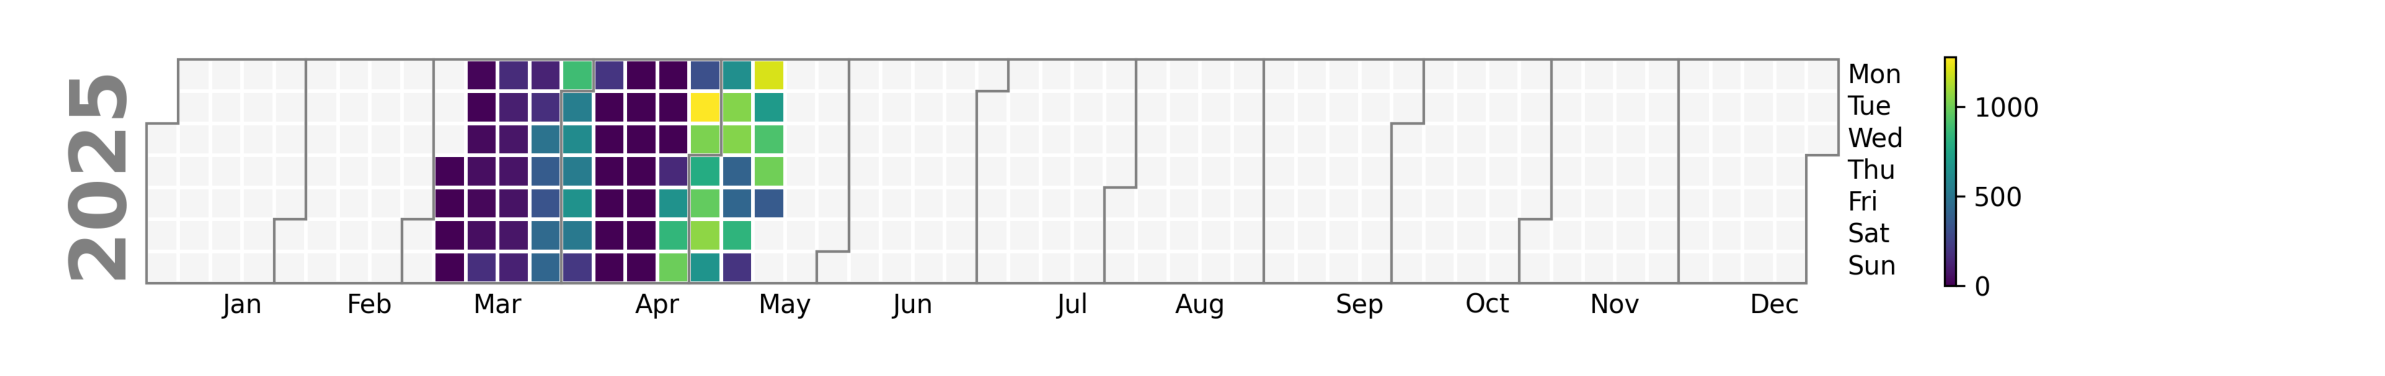

In [8]:
import lecilab_behavior_analysis.plots as plots
import lecilab_behavior_analysis.df_transforms as dft
df = dft.fill_missing_data(df)

# add a column with the date for the day
df = dft.add_day_column_to_df(df)

# create a figure with 1 axis for the calendar plot
import matplotlib.pyplot as plt
fig, ax_cal = plt.subplots(figsize=(10, 5), dpi=300)
# generate the calendar plot
dates_df = dft.get_dates_df(df)
cal_image = plots.rasterize_plot(plots.training_calendar_plot(dates_df), dpi=300)
# paste the calendar plot filling the entire axis
ax_cal.imshow(cal_image)
ax_cal.axis("off")

plt.show()

DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes._PyFloatDType'>, <class 'numpy.dtypes.StrDType'>)

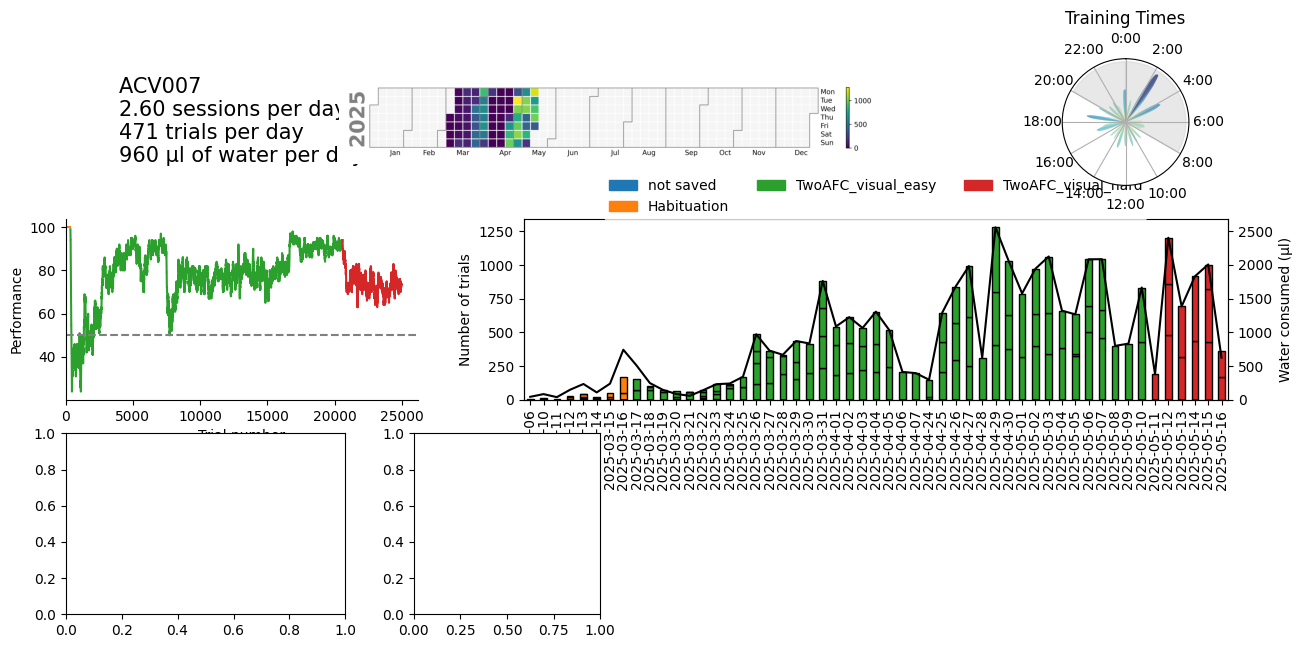

In [9]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
fig = subject_progress_figure(df, perf_window=100, summary_matrix_plot=False)

DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes._PyFloatDType'>, <class 'numpy.dtypes.StrDType'>)

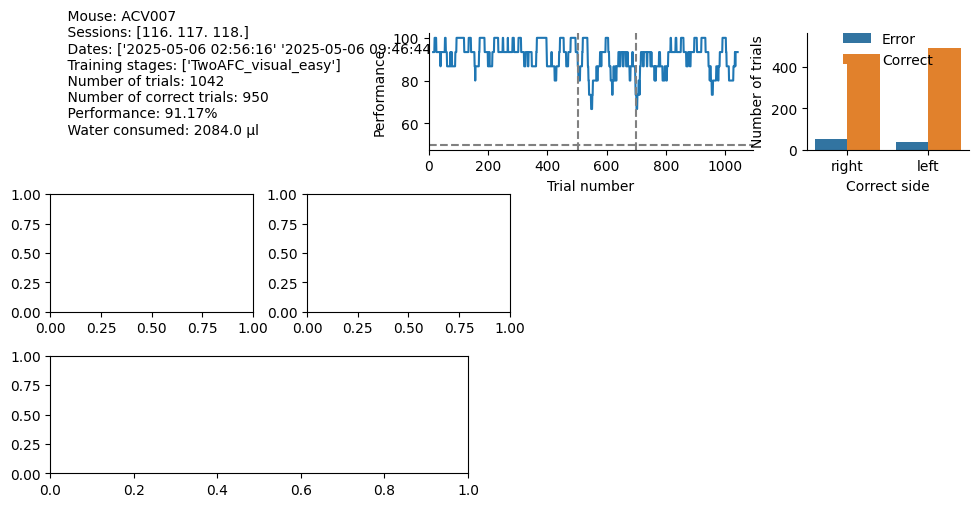

In [10]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
from lecilab_behavior_analysis.df_transforms import add_trial_of_day_column_to_df, add_day_column_to_df
# select the session you want to plot
date = "2025-05-06"
df = add_day_column_to_df(df)
df = add_trial_of_day_column_to_df(df)
sdf = df[df["year_month_day"] == date]
fig = session_summary_figure(sdf, mouse, perf_window=15, width=10, height=5)

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import df_transforms as dft
from sklearn.linear_model import LogisticRegression

In [83]:
df_test = df.dropna(subset = ['visual_stimulus'])

In [ ]:
df_test['visual_stimulus_devi'] = df_test['visual_stimulus'].apply(lambda x: abs(round(eval(x)[0] / eval(x)[1], 4)))
# df_test['visual_stimulus_devi'] = df_test.apply(
#     lambda row: row['visual_stimulus_devi'] if row['correct_side'] == 'left' else -row['visual_stimulus_devi'],
#     axis=1
# )
df_test['visual_stimulus_diff'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0] - eval(x)[1]))
df_test['visual_stimulus_diff'] = df_test.apply(
    lambda row: row['visual_stimulus_diff'] if row['correct_side'] == 'left' else -row['visual_stimulus_diff'],
    axis=1
)
df_test['left_choice'] = np.where((df_test['correct_side'] == 'left') & (df_test['correct'] == True), 1, 0)

/tmp/ipykernel_31405/1380778972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['visual_stimulus_devi'] = df_test['visual_stimulus'].apply(lambda x: abs(round(eval(x)[0] / eval(x)[1], 4)))
/tmp/ipykernel_31405/1380778972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['visual_stimulus_diff'] = df_test['visual_stimulus'].apply(lambda x: abs(eval(x)[0] - eval(x)[1]))
/tmp/ipykernel_31405/1380778972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

Text(0, 0.5, 'Probability of Left Choice')

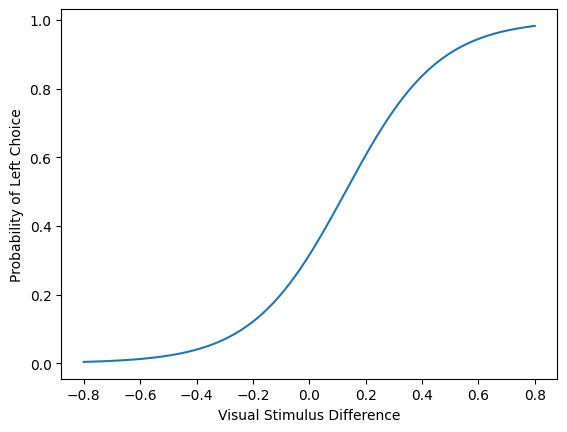

In [85]:
df_test_sorted = df_test.sort_values(by='visual_stimulus_diff')
X = df_test_sorted['visual_stimulus_diff'].values.reshape(-1, 1)
y = df_test_sorted['left_choice'].values.astype(int)
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]
plt.plot(X, y_prob)
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")

Text(0, 0.5, 'Probability of Left Choice')

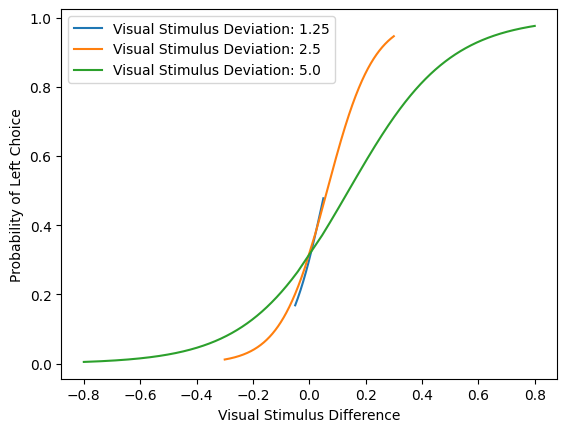

In [87]:
for i in df_test.groupby('visual_stimulus_devi'):
    df_i = i[1].sort_values(by='visual_stimulus_diff')
    X = df_i['visual_stimulus_diff'].values.reshape(-1, 1)
    y = df_i['left_choice'].values.astype(int)
    model = LogisticRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    plt.plot(X, y_prob, label=f"Visual Stimulus Deviation: {i[0]}")
    plt.legend()
plt.xlabel("Visual Stimulus Difference")
plt.ylabel("Probability of Left Choice")

In [25]:
from lecilab_behavior_analysis.plots import plot_time_between_trials_and_reaction_time
from lecilab_behavior_analysis.df_transforms import calculate_time_between_trials_and_reaction_time
session = 28
sdf = df[df["session"] == session]
ssdf = calculate_time_between_trials_and_reaction_time(sdf)
ssdf


/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/utils.py:354: RuntimeWarning: All-NaN axis encountered


,session,date,trial,subject,task,system_name,run_mode,Port1In,Port1Out,Port2In,...,correct_side,current_training_stage,difficulty,holding_time,ordered_list_of_events,stimulus_modality,visual_stimulus,water,Time_Between_Trials,Reaction_Time
684,28,2025-03-21 09:57:58,1,ACV001,TwoAFC,village01,Auto,"[1742547488.694504, 1742547488.8047042, 174254...","[1742547488.713504, 1742547501.665704, 1742547...","[1742547508.8814042, 1742547524.716604, 174254...",...,left,TwoAFC_visual_easy,easy,0.154,"['Tup', 'Port1In', 'Port1Out', 'Port1In', 'Por...",visual,"(0.3200608426610537, 0.06401216853221074)",0.0,NaN,11.2027
685,28,2025-03-21 09:57:58,2,ACV001,TwoAFC,village01,Auto,"[1742547614.665345, 1742547614.6867452, 174254...","[1742547614.611445, 1742547614.680845, 1742547...","[1742547618.816945, 1742547621.9755452]",...,left,TwoAFC_visual_easy,easy,0.154,"['Tup', 'Port1Out', 'Port1In', 'Port1Out', 'Po...",visual,"(0.9706356294319286, 0.19412712588638573)",0.0,30.440541,5.4949
686,28,2025-03-21 09:57:58,3,ACV001,TwoAFC,village01,Auto,"[1742547648.5111759, 1742547686.204376, 174254...","[1742547648.473676, 1742547648.5376759, 174254...","[1742547689.946076, 1742547691.4740758, 174254...",...,left,TwoAFC_visual_easy,easy,0.154,"['Tup', 'Port1Out', 'Port1In', 'Port1Out', 'Po...",visual,"(0.3755521262223999, 0.07511042524447999)",4.0,78.677231,0.9172
687,28,2025-03-21 09:57:58,4,ACV001,TwoAFC,village01,Auto,"[1742547724.203294, 1742547724.713794]","[1742547713.206394, 1742547724.688794, 1742547...","[1742547718.161994, 1742547718.9861941, 174254...",...,right,TwoAFC_visual_easy,easy,0.155,"['Tup', 'Port1Out', 'Port2In', 'Port2Out', 'Po...",visual,"(0.7829795743975531, 0.1565959148795106)",4.0,26.500118,NaN
688,28,2025-03-21 09:57:58,5,ACV001,TwoAFC,village01,Auto,[1742547748.4447591],NaN,[1742547747.3376591],...,left,TwoAFC_visual_easy,easy,0.156,"['Tup', 'Port3Out', 'Port2In', 'Tup', 'Port2Ou...",visual,"(0.5952417751657763, 0.11904835503315525)",4.0,20.158965,0.8436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,28,2025-03-21 09:57:58,57,ACV001,TwoAFC,village01,Auto,[1742549191.532059],[1742549185.255759],"[1742549188.454859, 1742549188.468159, 1742549...",...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1Out', 'Port2In', 'Port2Out', 'Po...",visual,"(0.7301231329494715, 0.1460246265898943)",0.0,9.999225,2.8206
741,28,2025-03-21 09:57:58,58,ACV001,TwoAFC,village01,Auto,"[1742549201.7528021, 1742549201.803702, 174254...","[1742549194.1438022, 1742549201.777102, 174254...",[1742549196.3671021],...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1Out', 'Port2In', 'Tup', 'Port2Ou...",visual,"(0.10430738199521679, 0.020861476399043358)",0.0,7.837843,5.2035
742,28,2025-03-21 09:57:58,59,ACV001,TwoAFC,village01,Auto,[1742549214.749625],"[1742549204.7713249, 1742549215.744825]","[1742549207.951825, 1742549213.8180249]",...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1Out', 'Port2In', 'Tup', 'Port2Ou...",visual,"(0.9380965794202032, 0.18761931588404063)",0.0,17.323023,0.8773
743,28,2025-03-21 09:57:58,60,ACV001,TwoAFC,village01,Auto,"[1742549215.76945, 1742549225.67055]",[1742549219.79175],[1742549222.02265],...,left,TwoAFC_visual_easy,easy,0.167,"['Tup', 'Port1In', 'Port1Out', 'Port2In', 'Tup...",visual,"(0.5908522719549152, 0.11817045439098305)",0.0,8.345525,3.4527


<Axes: ylabel='Frequency'>

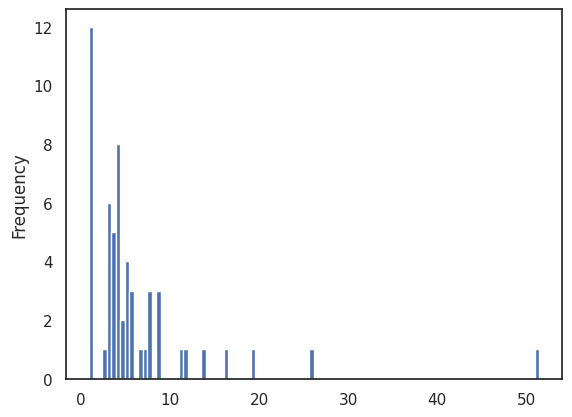

In [29]:
ssdf.Reaction_Time.plot(kind="hist", bins=100)